In [1]:
cd /home/icb/alessandro.palma/imCPA

/mnt/home/icb/alessandro.palma/imCPA


In [2]:
import torch
import os
import pandas as pd
from scipy.io import mmread
import numpy as np
from training_utils import *
from models.vae.sigmaVAE import *
from tqdm import tqdm
from utils import *

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

### Import the configuration file and initialize the training object 

In [ ]:
# Load model checkpoint
config =  Config(config_path = '/home/icb/alessandro.palma/imCPA/configs/config_sigma_vae.json') 
# Initialize the trainer 
t = Trainer(config)

In [ ]:
# Load the pre-trained weights 
checkpoint = torch.load('/home/icb/alessandro.palma/checkpoints/vae_resid10_dim100')

In [ ]:
# Load the pre-trained model
model = t.model.module
# Avoid data augmentation on training set 
t.training_set.transform.test = True

model.load_state_dict(checkpoint['model_state_dict'])

### Derive the embeddings for training, test and validation set 

In [ ]:
# Collect predictions on the test set 
zs_train = np.empty((1,t.model_config['latent_dim']))
zs_test = np.empty((1,t.model_config['latent_dim']))
zs_valid = np.empty((1,t.model_config['latent_dim']))

# Evaluate model 
model.eval()
zs = [zs_train, zs_test, zs_valid]
mol_names = [[],[],[]]
file_names = [[], [], []]

# Do a forward pass to avoid the 
for i, loader in enumerate([t.loader_train, t.loader_test, t.loader_val]):
    for batch in tqdm(loader):
        X_batch = batch['X'].to(t.device)
        with torch.no_grad():
            _, z, _ = model.get_latent_representation(X_batch).values()
            zs[i] = np.vstack((zs[i], z.to('cpu').numpy()))
        # mol_names[i] += batch['mol_name']
        # file_names[i] += batch['file_name']

zs = [z[1:] for z in zs]

In [ ]:
# Assign the three zs to different arrays
zs_train, zs_test, zs_valid = zs

**For the three splits, plot the UMAP of the latent spaces**

In [41]:
# Set seaborn figure
sns.set(style='white', context='notebook', rc={'figure.figsize':(5,5)})

In [ ]:
# Now use umap reducer to plot latent space
reducer = umap.UMAP()

embedding_train = reducer.fit_transform(zs_train)
embedding_test = reducer.fit_transform(zs_test)
embedding_valid = reducer.fit_transform(zs_valid)

In [42]:
# Assign colours and indices to clusters
def plot_umap(embedding, title, x_thresh=8, y_thresh=0):
    # Cluster names 
    idx_clus = [2,3]
    idx_clus1 = [i  for i in range(len(embedding[:,0])) if np.logical_and(embedding[i,0]>x_thresh, embedding[i,1]>y_thresh)]
    #idx_clus2 = [i  for i in range(len(embedding[:,0])) if np.logical_and(embedding[i,0]<x_thresh, embedding[i,1]<y_thresh)]
    idx_clus2 = list(set(range(len(embedding[:,0])))-set(idx_clus1))
    
    clus2col = ['firebrick', 'darkcyan']

    for i, clus in enumerate([idx_clus1, idx_clus2]):   
        plt.scatter(
            embedding[clus, 0],
            embedding[clus, 1], c=clus2col[i], edgecolors='black', label= f'Cluster{i}')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=24)
    plt.xlabel('Embedding 1')
    plt.ylabel('Embedding 2')
    plt.legend()
    plt.plot()
    return idx_clus1, idx_clus2

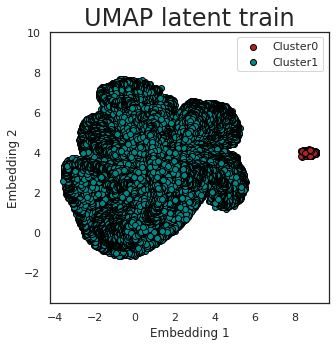

In [43]:
clustered_train, _ = plot_umap(embedding_train, 'UMAP latent train', 8, 2)

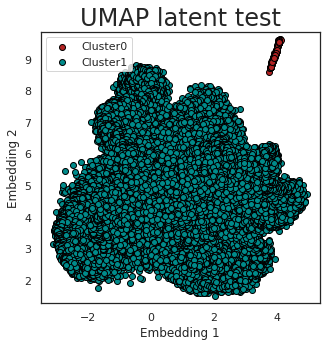

In [44]:
clustered_test, _ = plot_umap(embedding_test, 'UMAP latent test', 3, 8)

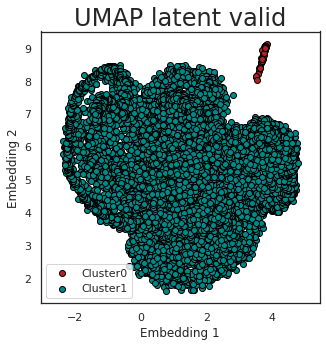

In [45]:
clustered_valid, _ = plot_umap(embedding_valid, 'UMAP latent valid', 3, 7)

**Collect the extreme images in the plots**

In [ ]:
# Cluster names 
clus_mols_train = [mol_names[0][i] for i in clustered_train]
clus_mols_test = [mol_names[1][i] for i in clustered_test]
clus_mols_valid = [mol_names[2][i] for i in clustered_valid]

# Cluster filenames
clus_names_train = [file_names[0][i] for i in clustered_train]
clus_names_test = [file_names[1][i] for i in clustered_test]
clus_names_valid = [file_names[2][i] for i in clustered_valid]

In [ ]:
len(clus_names_train)+len(clus_names_valid)+len(clus_names_test)

**Detect an outlier for all three datasets**


In [ ]:
# Visualize the cells that clustered far from the rest 
print('Best outlier train: ', clus_mols_train[np.argmax(np.unique(clus_mols_train, return_counts = True)[1])])
print('Best outlier valid: ', clus_mols_valid[np.argmax(np.unique(clus_mols_valid, return_counts = True)[1])])
print('Best outlier test: ', clus_mols_test[np.argmax(np.unique(clus_mols_test, return_counts = True)[1])])

### Plot the images of the separate cluster

In [31]:
def plot_channel_panel(image, rgb = False):
    """
    Plot a panel of single channel figures 
    -------------------
    image: numpy array of dimension (height, width, 5)
    """
    if not rgb:
        fig, axs = plt.subplots(1, 5, figsize = (15,4))
        fig.suptitle('5 channel image', fontsize=16)
        for z in range(image.shape[-1]):
            axs[z].imshow(image[:,:,z], cmap = 'Greys')
            axs[z].axis('off')
    else:
        fig = plt.figure(figsize  = (3,3))
        plt.imshow(image[:,:,[0,2,4]])
        plt.axis('off')
    plt.plot()

In [ ]:
# Collect outliers
clus_mols = [clus_mols_train, clus_mols_test, clus_mols_valid]

In [ ]:
# Collect images of outliers
mol2img_outliers = [dict(), dict(), dict()]
for i, loader in enumerate([t.loader_train, t.loader_test, t.loader_val]):
    for batch in tqdm(loader):
        # Extract the names of the molecule and the files 
        mols = batch['mol_name']
        file_names = batch['file_name']
        # Extract the images of the molecules 
        pos = [j for j in range(len(mols)) if mols[j] in clus_mols[i]]
        for j in pos:
            mol2img_outliers[i][file_names[j]] = [mols[j], tensor_to_image(batch['X'].to('cpu')[j,:])]

In [50]:
mol2img_outliers[0]['26204-M05-2'][1].shape

(100, 100, 5)

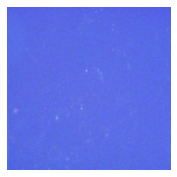

In [51]:
plot_channel_panel(mol2img_outliers[0]['24320-H21-1'][1], rgb=True)

### Save results

In [9]:
# # Save the results
# np.savez('/home/icb/alessandro.palma/imCPA/data/metadata_processed/compounds_and_embeddings.npz', clus_mols=clus_mols, 
#           embedding_train=embedding_train, embedding_valid=embedding_valid, embedding_test=embedding_test, 
#           mol2img_outliers=mol2img_outliers)

# Load
res = np.load('/home/icb/alessandro.palma/data/metadata_processed/compounds_and_embeddings.npz', allow_pickle = True)

In [ ]:
# Used if data are loaded 
clus_names=res['clus_mols'] 
embedding_train=res['embedding_train']
embedding_valid=res['embedding_valid']
embedding_test=res['embedding_test']
mol2img_outliers=res['mol2img_outliers']

In [ ]:
print(clus_names[0])

In [106]:
mol2img_outliers[1].keys()

dict_keys(['25704-H03-4', '25700-H03-6', '26058-C14-5', '24320-P16-2', '25968-D02-6', '25436-P04-6', '25989-O20-3', '24278-G12-4', '25989-P19-3', '25430-D21-5', '24312-C17-5', '24731-K09-1', '24320-P16-4', '24293-G12-1', '25380-O21-4', '25938-B24-2', '26232-G12-4', '25580-D08-4', '25605-P03-3', '26092-C14-1', '24295-B24-1', '24310-A10-5', '25588-I21-4', '25968-D02-5', '24321-P16-1', '24302-B22-4', '25683-E10-3', '24321-O20-4', '25592-I21-1', '24357-P19-3', '25681-E10-6', '25592-K05-3', '25588-K05-1', '25591-K05-5', '26224-G12-1', '26232-G12-6', '24321-P16-5', '25938-B24-4', '26110-I18-2', '25990-O20-4', '24311-A10-2', '25580-D08-5', '25583-P07-4', '24311-C17-5', '25944-B22-1', '25565-P13-6', '25988-A10-4', '25584-J21-3', '26124-A13-1', '25580-D08-6', '25591-K05-3', '24726-K09-2', '24303-B22-2', '26071-I18-2', '24279-J16-1', '25694-H03-5', '26118-A13-3', '25707-F06-2', '25587-P03-4', '24732-K09-3', '26071-I18-3', '26060-C16-1', '25581-D08-2', '25708-F06-6', '25991-P16-2', '25428-D21-5',

### Compare with ground truth

Check if the images of the loader correspond to the ones of the true data

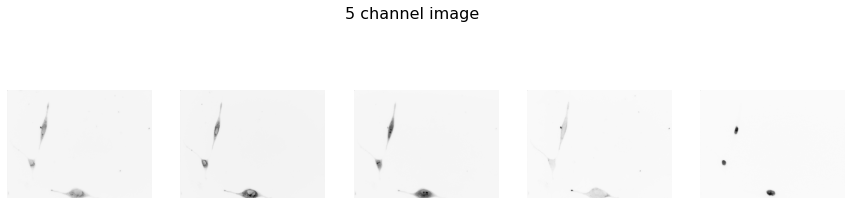

In [121]:
res = np.load('/storage/groups/ml01/workspace/alessandro.palma/cellpainting_512/25590-I21-5.npz')
res=res['sample']
plot_channel_panel(res, rgb=False)

### Test the sampling approach and SWD 

In [7]:
from metrics.swd_score import *

In [8]:
sample_generated = model.sample(1000, 1).detach().cpu()
#sample_generated = torch.randn(1000, 5, 100, 100).cpu()
sample_true = t.training_set.sample(1000)['X'].cpu()

In [9]:
SWD_metric = LaplacianSWDMetric(7, 128, 3)

In [10]:
SWD_metric.update_with_mini_batch(sample_generated, sample_true)
# del sample_generated
# del sample_true

In [11]:
SWD_metric.get_score()

111.76446949442227